In [1]:
import datetime as dt
import glob
import netCDF4 as nc
import numpy as np
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
from gsw import sigma0

import yaml

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = './cartopy_shapefiles'

os.getcwd()

'/home1/datahome/mlejeune'

In [2]:
with open(r'configuration.yaml') as file:
    configuration = yaml.load(file, Loader=yaml.FullLoader)

    print("File version: ", configuration["version"])

File version:  0.1


In [4]:
#Put the MDT, bathy etc on the SLA grid
#Create the grid of SLA
path = configuration['SLA_path']
ds_sla = xr.open_mfdataset(path + configuration['SLA_prefix'] + '*.nc',combine='nested', concat_dim='time')
ds_sla = ds_sla.assign_coords(lon180=(((ds_sla.longitude + 180) % 360) - 180))  
ds_sla['longitude'] = ds_sla.lon180



ds_input = xr.Dataset({'lat': (['lat'], ds_sla.latitude.data),
                     'lon': (['lon'], ds_sla.longitude.data),
                    'time':(['time'], ds_sla.time.data)})



sla   = ds_sla.interp(latitude=ds_input.lat,longitude=ds_input.lon,method = 'linear')['sla'].astype(np.float32).values
ugos  = ds_sla.interp(latitude=ds_input.lat,longitude=ds_input.lon,method = 'linear')['ugos'].astype(np.float32).values
vgos  = ds_sla.interp(latitude=ds_input.lat,longitude=ds_input.lon,method = 'linear')['vgos'].astype(np.float32).values
ugosa = ds_sla.interp(latitude=ds_input.lat,longitude=ds_input.lon,method = 'linear')['ugosa'].astype(np.float32).values
vgosa = ds_sla.interp(latitude=ds_input.lat,longitude=ds_input.lon,method = 'linear')['vgosa'].astype(np.float32).values
sla_err = ds_sla.interp(latitude=ds_input.lat,longitude=ds_input.lon,method = 'linear')['err'].astype(np.float32).values

ds_input = ds_input.assign(variables={"SLA": (("time","lat","lon"),sla)})  
ds_input = ds_input.assign(variables={"UGOS": (("time","lat","lon"),ugos)})  
ds_input = ds_input.assign(variables={"VGOS": (("time","lat","lon"),vgos)})  
ds_input = ds_input.assign(variables={"UGOSA": (("time","lat","lon"),ugosa)})  
ds_input = ds_input.assign(variables={"VGOSA": (("time","lat","lon"),vgosa)})
ds_input = ds_input.assign(variables={"SLA_err": (("time","lat","lon"),sla_err)})
del ds_sla,sla,ugos,vgos,ugosa,vgosa,sla_err
ds_input

<xarray.Dataset>
Dimensions:  (lat: 84, lon: 264, time: 9861)
Coordinates:
  * lat      (lat) float32 60.12 60.38 60.62 60.88 ... 80.12 80.38 80.62 80.88
  * lon      (lon) float32 -40.88 -40.62 -40.38 -40.12 ... 24.38 24.62 24.88
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-31
Data variables:
    SLA      (time, lat, lon) float32 -0.0455 -0.0503 -0.0573 ... 0.0721 0.0717
    UGOS     (time, lat, lon) float32 -0.0617 -0.0574 -0.0504 ... 0.0014 0.0014
    VGOS     (time, lat, lon) float32 -0.1222 -0.1235 -0.1028 ... -0.0007 0.033
    UGOSA    (time, lat, lon) float32 -0.014 -0.0179 -0.0164 ... -0.0133 -0.0138
    VGOSA    (time, lat, lon) float32 -0.0162 -0.0371 ... -0.0105 -0.0015
    SLA_err  (time, lat, lon) float32 0.0157 0.0149 0.014 ... 0.0245 0.0245

In [5]:
%%time

#rename variable
ds_bat = xr.open_dataset(configuration['BATHYMETRIE_path'])
ds_bat = ds_bat.rename({'x': 'LONGITUDE','y': 'LATITUDE'})

#Load Bathy
ds_bat = xr.open_dataset(configuration['BATHYMETRIE_output_path'] + configuration['BATHYMETRIE_FILE_NAME'])
ds_bat = ds_bat.expand_dims("TIME")
bat = ds_bat.interp(LATITUDE=ds_input.lat,LONGITUDE=ds_input.lon,method = 'linear')['bathymetry'].astype(np.float32).squeeze().values
#bat_rep = np.repeat(bat,len(ds_input.time),axis = 0)
ds_input = ds_input.assign(variables={"BATHY": (("lat","lon"),bat)})  
del ds_bat,bat

CPU times: user 56 ms, sys: 64 ms, total: 120 ms
Wall time: 1.18 s


In [6]:
%%time
#Load MDT and subsample
ds_mdt = xr.open_dataset(configuration['MDT_DATA_path'])
ds_mdt = ds_mdt.assign_coords(lon180=(((ds_mdt.longitude + 180) % 360) - 180))  
ds_mdt['longitude'] = ds_mdt.lon180

mdt = ds_mdt.interp(latitude=ds_input.lat,longitude=ds_input.lon,method = 'linear')['mdt'].astype(np.float32).squeeze().values
#mdt_rep = np.repeat(mdt,len(ds_input.time),axis =0)
ds_input = ds_input.assign(variables={"MDT": (("lat","lon"),mdt)})  
del ds_mdt,mdt

CPU times: user 208 ms, sys: 1.21 s, total: 1.42 s
Wall time: 1.58 s


In [7]:
%%time
#Load SST and subsample
path = configuration['SST_output_path']
ds_sst = xr.open_mfdataset(path + '*.nc',combine='nested', concat_dim='time')

sst = ds_sst.interp(lat=ds_input.lat,lon=ds_input.lon,method = 'linear')['analysed_sst'].values
sstE = ds_sst.interp(lat=ds_input.lat,lon=ds_input.lon,method = 'linear')['analysis_uncertainty'].values

ds_input = ds_input.assign(variables={"SST": (("time","lat","lon"),sst-273.15)})  
ds_input = ds_input.assign(variables={"SST_uncertainty": (("time","lat","lon"),sstE)})
del ds_sst,sst,sstE

ds_input.to_netcdf('/home1/datahome/mlejeune/grilled/output/Gridded_input_v3_intermediate.nc')
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


CPU times: user 1min 24s, sys: 56.6 s, total: 2min 21s
Wall time: 3min 43s


In [3]:
ds_input = xr.open_dataset('/home1/datahome/mlejeune/grilled/output/Gridded_input_v3_intermediate.nc')
ds_input

<xarray.Dataset>
Dimensions:          (lat: 84, lon: 264, time: 9861)
Coordinates:
  * lat              (lat) float32 60.12 60.38 60.62 60.88 ... 80.38 80.62 80.88
  * lon              (lon) float32 -40.88 -40.62 -40.38 ... 24.38 24.62 24.88
  * time             (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-31
Data variables:
    SLA              (time, lat, lon) float32 ...
    UGOS             (time, lat, lon) float32 ...
    VGOS             (time, lat, lon) float32 ...
    UGOSA            (time, lat, lon) float32 ...
    VGOSA            (time, lat, lon) float32 ...
    SLA_err          (time, lat, lon) float32 ...
    BATHY            (lat, lon) float32 ...
    MDT              (lat, lon) float32 ...
    SST              (time, lat, lon) float32 ...
    SST_uncertainty  (time, lat, lon) float32 ...

In [4]:
ds_input = ds_input.where(ds_input.BATHY < -1000)

mask_ocean = 1 * np.ones((ds_input.dims['lat'], ds_input.dims['lon'])) * np.isfinite(ds_input.SST.isel(time=0))  
mask_land = 0 * np.ones((ds_input.dims['lat'], ds_input.dims['lon'])) * np.isnan(ds_input.SST.isel(time=0))  
mask_array = mask_ocean + mask_land

ds_input.coords['mask'] = (('lat', 'lon'), mask_array.data)
ds_input = ds_input.where(ds_input['mask'] == 1)


{0.0, 4.0}


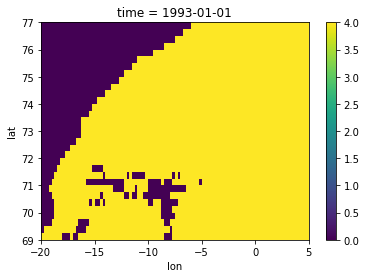

In [5]:
#Remove the border that do not correspond between surface datasets
ds_input = ds_input.where((ds_input['lon']>=configuration['longitude1']) & (ds_input['lon']<=configuration['longitude2']) & (ds_input['lat']>=configuration['latitude2']) & 
              (ds_input['lat']<=configuration['latitude1']), drop=True)

#Verification that each gridpoint is either NaN or value (0 or 5)
mask_SST = 1 * np.ones((ds_input.dims['lat'], ds_input.dims['lon'])) * np.isfinite(ds_input.SST.isel(time=0))  
mask_SLA = 1 * np.ones((ds_input.dims['lat'], ds_input.dims['lon'])) * np.isfinite(ds_input.SLA.isel(time=0))  
mask_MDT = 1 * np.ones((ds_input.dims['lat'], ds_input.dims['lon'])) * np.isfinite(ds_input.MDT)  
mask_BAT = 1 * np.ones((ds_input.dims['lat'], ds_input.dims['lon'])) * np.isfinite(ds_input.BATHY)  
mask_sum = mask_SST + mask_SLA + mask_MDT + mask_BAT
mask_sum.plot()
print(set(np.array(mask_sum).flatten()))

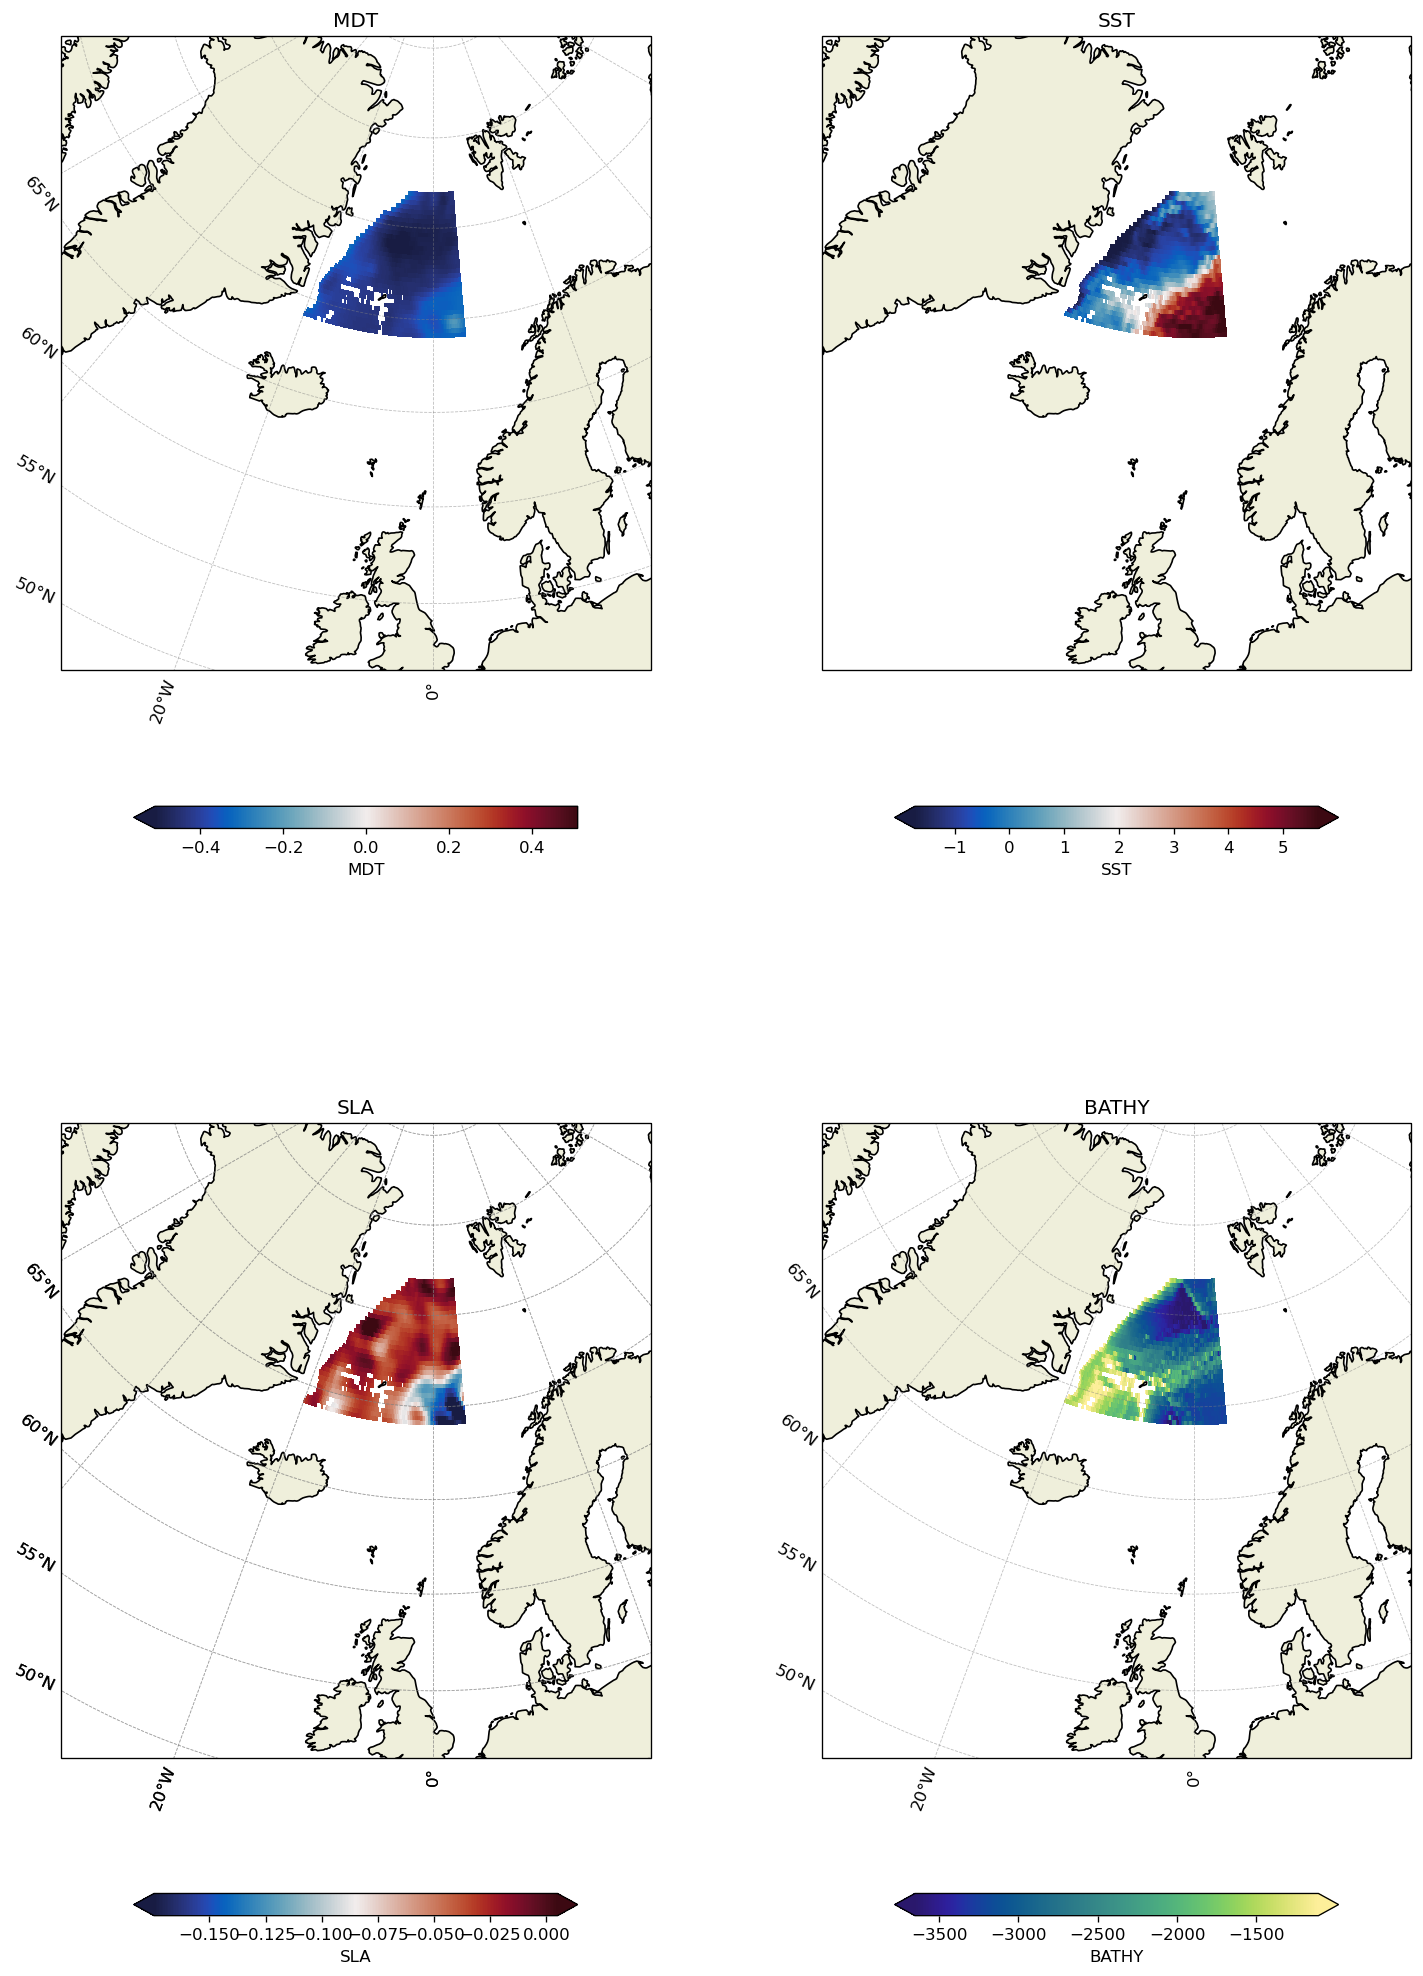

In [20]:
#Verif Maps
proj=ccrs.NorthPolarStereo()
land_feature = cfeature.NaturalEarthFeature(
    category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
extent = np.array([17, -30, 50, 85])

subplot_kw = {'projection': proj, 'extent': extent}

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 22), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
ds_input['MDT'].plot(ax=ax[0,0],
                  cmap=cmocean.cm.balance,center=0,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"orientation": "horizontal", "shrink": 0.7},
                  robust=True)
ax[0,0].contour(ds_input['lon'],ds_input['lat'],ds_input['MDT'],colors = "black",linewidths = 1)
ax[0,0].add_feature(land_feature, edgecolor='black')
gl = ax[0,0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax[0,0].set_title('MDT')

ds_input['SST'].isel(time = 0).plot(ax=ax[0,1],
                  cmap=cmocean.cm.balance,center=False,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"orientation": "horizontal", "shrink": 0.7},
                  robust=True)
ax[0,1].contour(ds_input['lon'],ds_input['lat'],ds_input['SST'].isel(time = 0),colors = "black",linewidths = 1)
ax[0,1].add_feature(land_feature, edgecolor='black')
gl = ax[1,0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax[0,1].set_title('SST')


ds_input['SLA'].isel(time = 0).plot(ax=ax[1,0],
                  cmap=cmocean.cm.balance,center=False,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"orientation": "horizontal", "shrink": 0.7},
                  robust=True)
ax[1,0].contour(ds_input['lon'],ds_input['lat'],ds_input['SLA'].isel(time = 0),colors = "black",linewidths = 1)
ax[1,0].add_feature(land_feature, edgecolor='black')
gl = ax[1,0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax[1,0].set_title('SLA')


ds_input['BATHY'].plot(ax=ax[1,1],
                  cmap=cmocean.cm.haline,center=False,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"orientation": "horizontal", "shrink": 0.7},
                  robust=True)
ax[1,1].contour(ds_input['lon'],ds_input['lat'],ds_input['BATHY'],colors = "black",linewidths = 1)
ax[1,1].add_feature(land_feature, edgecolor='black')
gl = ax[1,1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax[1,1].set_title('BATHY')


#plt.savefig('/home/datawork-lops-bluecloud/osnet/remote_sensing_data/Gridded_output_fig.png', transparent=False)
plt.show()

In [25]:
#Final save
ds_input.to_netcdf('/home/datawork-lops-bluecloud/osnet/grilled_Nordic_Sea/Gridded_input.nc')